# Dummy data
**Goal**: Create dummy data to test the estimator on

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def generate_data(x, function, noise_std):
    return function(x)+ np.random.normal(loc=0, scale=noise_std, size=x.shape)

In [16]:
x = np.arange(10)

def random_x(left, right, size):
    """Generate n random data-points between left and right"""
    return (right-left) * np.random.random(size=size) + left




In [34]:
x = random_x(-10, 10, 100)
y = generate_data(x, np.sin, 1)

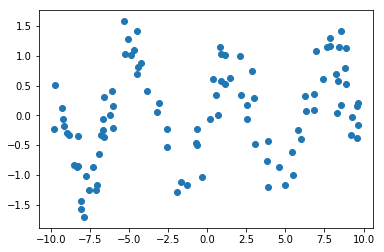

In [45]:
plt.scatter(x, np.sin(x) + np.random.normal(loc=0, scale=0.3, size=x.shape))